In [1]:
from skimage import io as skio

import scipy.io
import math
from glob import glob

In [10]:
from scipy.optimize import least_squares



In [2]:
from tqdm import tqdm

In [3]:
import numpy as np

In [4]:
from matplotlib import pyplot as plt

In [5]:
import pickle

In [6]:
from skimage.transform import resize


### Get the all the points for a breed

In [7]:
top_breeds = ['005.alaskan_malamute','015.basset_hound','029.border_collie','039.bull_terrier','057.dalmatian','041.bullmastiff','087.irish_terrier','056.dachshund','016.beagle','012.australian_shepherd']

In [8]:
with open('../sfm_warp_data/mean_points.pickle', 'rb') as handle:
    mean_points_2d = pickle.load(handle)
with open('../sfm_warp_data/3d_points.pickle', 'rb') as handle:
    points_meanaligned_3d = pickle.load(handle)

REMEMBEr

gamma - rotation around X axis (look up / look down)

beta - rotation around Y axis (look left/ look right)

alpha - rotation around Z axis (tilt da head)

In [17]:
def angle_estimation_loss(arr, orig, target):
    
    # arr: alpha, beta, gamma, scale
    
    tmx, T = reconstruct_tmx(arr)
    rotated_2d = (tmx @ orig)[:2]
    
    translated = rotated_2d + T
    errors = (translated - target) ** 2
    errors = np.mean(errors, axis = 0)
    
    return errors
    
def reconstruct_tmx(arr):
    alpha, beta, gamma, scale, tx, ty = arr
    ca, cb, cg = math.cos(alpha), math.cos(beta), math.cos(gamma)
    sa, sb, sg = math.sin(alpha), math.sin(beta), math.sin(gamma)
    rotation = [[ca * cb, (ca*sb*sg) - (sa*cg), (ca*sb*cg) + (sa*sg)],
                [sa*cb, (sa*sb*sg) + (ca*cg), (sa*sb*cg) - (ca*sg)],
                [- sb, cb * sg, cb * cg]]
    
    rmx = np.array(rotation)
    rmx = rmx * scale
    
    T = np.array([[tx],[ty]])
    
    return rmx, T

In [32]:
camera_mts = {}

for BREED in tqdm(top_breeds):
    breed_mats = glob(f'../CU_dogs/training_133/{BREED}/*v5.mat')
    breed_mats.sort()
    
    output = []
    
    points_3d = points_meanaligned_3d[BREED]
    
    for name in breed_mats:
        mat = scipy.io.loadmat(name)
        points = mat['points']
        img = mat['Imask']
        points = np.array(points)
        
        optimum = scipy.optimize.least_squares(angle_estimation_loss,
                                       np.array([0,0,0,1, 0, 0]),
                                       bounds=([-1.57, -1.57, -1.57, 0.25, -224, -224], [1.57, 1.57, 1.57, 4, 224, 224]),
                                       ftol = None,
                                       args=[points_3d, points])
        
        
        x = optimum.x
        
        M, T = reconstruct_tmx(x)
        
        alpha, beta, gamma, scale, _, _ = x
        
        output.append({
            'M': M,
            'T': T,
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma,
            'scale': scale
        })
        
    camera_mts[BREED] = output
        
  
    
    


100%|███████████████████████████████████████████| 10/10 [00:46<00:00,  4.67s/it]


In [34]:
with open('../sfm_warp_data/camera_mts.pickle', 'wb') as handle:
    pickle.dump(camera_mts, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [35]:
BREED = top_breeds[0]

In [37]:
alphas = [d['alpha'] for d in camera_mts[BREED]]
betas = [d['beta'] for d in camera_mts[BREED]]
gammas = [d['gamma'] for d in camera_mts[BREED]]

(array([ 2.,  7., 12., 10.,  8.,  5.,  5.,  3.,  2.,  3.]),
 array([-0.13038476, -0.10074712, -0.07110947, -0.04147183, -0.01183419,
         0.01780345,  0.0474411 ,  0.07707874,  0.10671638,  0.13635402,
         0.16599167]),
 <BarContainer object of 10 artists>)

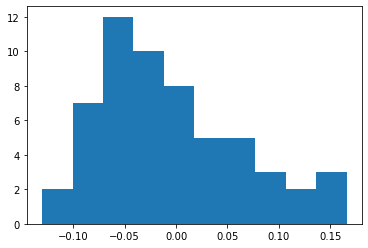

In [41]:
plt.hist(alphas)

(array([ 5.,  2., 10.,  6., 12.,  6.,  3.,  6.,  3.,  4.]),
 array([-0.58592463, -0.45486981, -0.32381499, -0.19276017, -0.06170535,
         0.06934947,  0.2004043 ,  0.33145912,  0.46251394,  0.59356876,
         0.72462358]),
 <BarContainer object of 10 artists>)

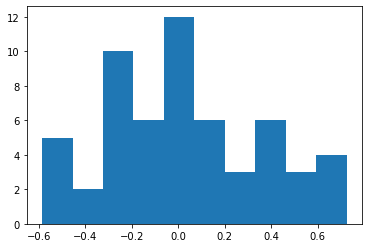

In [42]:
plt.hist(betas)

(array([ 1.,  2.,  1.,  5.,  9.,  9., 10., 10.,  4.,  6.]),
 array([-0.57791635, -0.47169252, -0.36546869, -0.25924485, -0.15302102,
        -0.04679718,  0.05942665,  0.16565048,  0.27187432,  0.37809815,
         0.48432199]),
 <BarContainer object of 10 artists>)

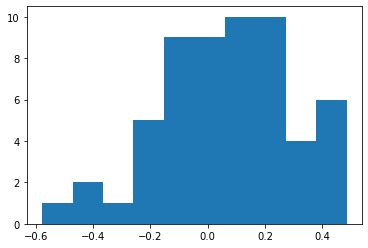

In [43]:
plt.hist(gammas)